# **Actividad de Serie de Tiempo**.

In [171]:
import yfinance as yf
import numpy as np, pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict 
from sklearn.metrics import r2_score
import statsmodels.tsa.api as smtsa
import matplotlib.pyplot as plt
import seaborn as sns

Para esta actividad se tomarán datos historicos de la api de Yahoo finance de la empresa **Microsoft**, se trabajará con los registros desde enero de 2024 hasta julio de 2024.

In [172]:
ticker_symbol = 'MSFT'

data = yf.download(ticker_symbol, start="2024-01-01", end="2024-07-31")

[*********************100%***********************]  1 of 1 completed


In [173]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,373.859985,375.899994,366.769989,370.869995,368.854095,25258600
2024-01-03,369.010010,373.260010,368.510010,370.600006,368.585571,23083500
2024-01-04,370.670013,373.100006,367.170013,367.940002,365.940002,20901500
2024-01-05,368.970001,372.059998,366.500000,367.750000,365.751038,20987000
2024-01-08,369.299988,375.200012,369.010010,374.690002,372.653351,23134000


In [174]:
data.shape

(145, 6)

## **Comportamiento de la serie de tiempo:**

Analizamos los gráfica de la serie original, su gráfico de autocorrelación y autocorrelación parcial del cierre ajustado del los registros de microsoft en le primer semestre de 2024.

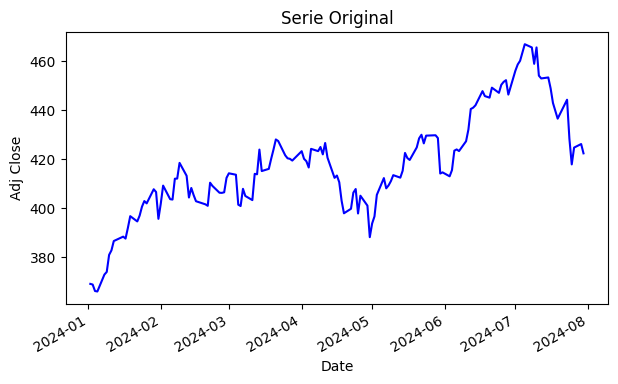

In [175]:
plt.rcParams.update({'figure.figsize': (7, 4)})
plt.rcParams['text.usetex'] = False  # Desactivar el uso de LaTeX

nlag = 50

# Serie original
data['Adj Close'].plot(color='b')
plt.title('Serie Original')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()



Al obtener la gráfica de la serie original, podemos ver que hay cierta tendencia de aumento al paso del tiempo, solo con esto no se puede decir si esta serie es estacionaria o no, se debe hacer la prueba analítica correspondiente.

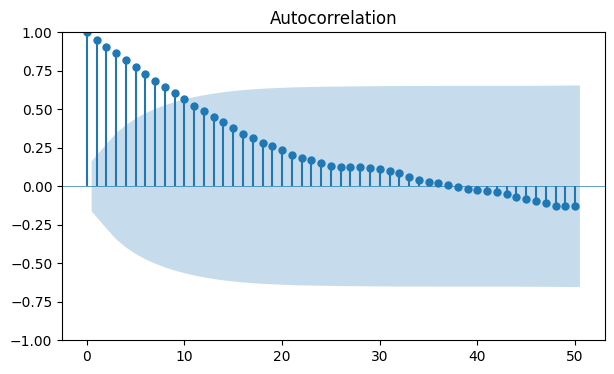

In [176]:
# Autocorrelación y autocorrelación parcial
plot_acf(data['Adj Close'], lags=nlag, linewidth=0.5)  # Autocorrelación
plt.show()

Si vemos el gráfica de autocorrelación vemos que el dato actual de nuestra serie de tiempo esta muy correlacionado o influenciado con sus observaciones inmediatas del pasado, además vemos que esta correlación va disminuyendo al tomar datos muy distantes en el pasado.

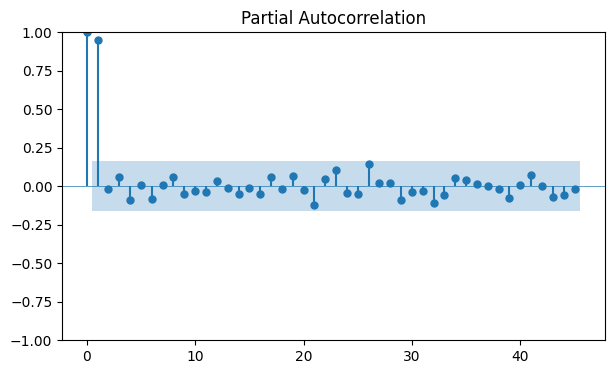

In [177]:
plot_pacf(data['Adj Close'], lags=45, linewidth=0.5)  # Autocorrelación Parcial
plt.show()

Y por ultimo si tomamos en cuenta el gráfico de autocorrelación parcial se puede ver una gran influencia en los primeros os datos inmediatos del pasado y una gran caída al comparar el resto de las observaciones.

**Prueba de Duckey-Fuller aumentada**

In [178]:
adf_result = adfuller(data["Adj Close"].tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' %adf_result[1])

ADF Statistic: -2.522702
p-value: 0.110048


con un p-valor de 0.11 el cual es mayor al nivel de significancia de 0.05 por tanto no se rechaza la hipotesis nula lo que indica que la serie es no estacionaria, por lo cual se debe implementar un modelo **ARIMA**.

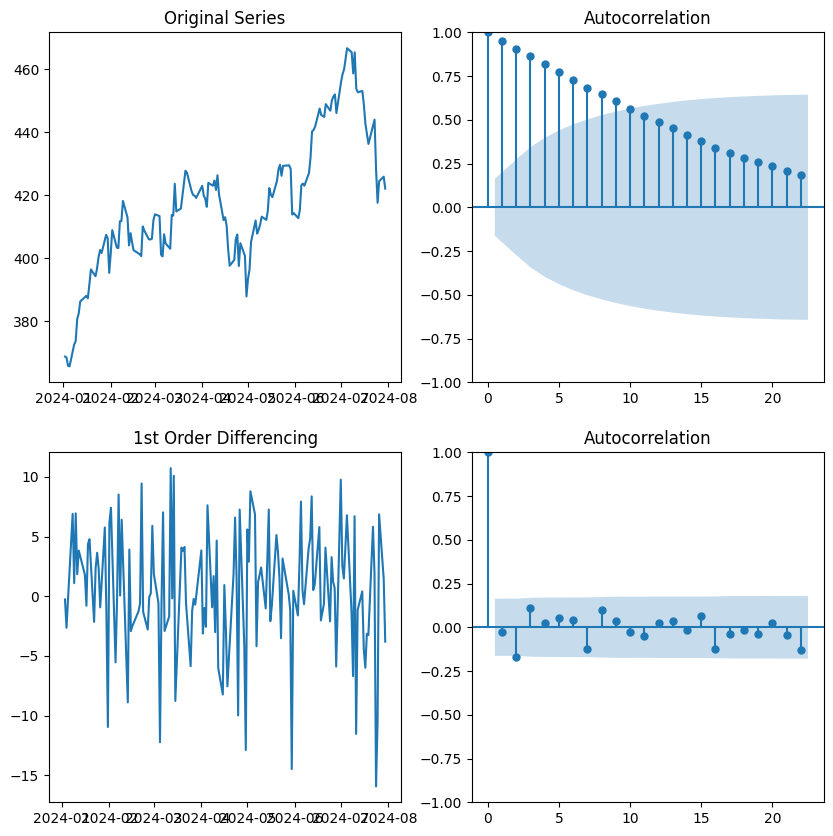

In [179]:
plt.rcParams.update({'figure.figsize': (10,10)})
fig, axes = plt.subplots(2, 2, sharex=False)

axes[0, 0].plot(data['Adj Close'])
axes[0, 0].set_title('Original Series')

plot_acf(data['Adj Close'], ax=axes[0, 1])

data_diff = data['Adj Close'].diff().dropna()
axes[1, 0].plot(data_diff)
axes[1, 0].set_title('1st Order Differencing')

plot_acf(data_diff, ax=axes[1, 1])
plt.show()

Con los resultados de la prueba analítica de Duckey-Fuller establecimos que la serie es no estacionaria, por tanto, es importante tener una idea de cuantas diferenciaciones se necesitarán para volver la serie estacionaria, mediante el gráfico anterior podemos ver que este parametro de diferenciación en el modelo ARIMA $d$ debe ser 1, puesto que con una sola diferenciación la serie ya se mira estacionaria y su autocorrelación demuestra esto mismo.

Con estos preeliminares podemos pasar a buscar cuales son los mejores parametros para nuestro modelo ARIMA, estos se escogeran teniendo en cuenta los criterios de AIC, BIC y HQIC.

## **Busqueda de los mejores parametros teniendo en cuenta los criterios AIC, BIC y HQIC**

Busqueda manueal de los mejores parametros:

In [180]:
model_scores = []

for d in range(1, 3):
    for ari in range(1, 3):
        for maj in range(1, 3):
            try:
                # Ajuste del modelo ARIMA
                arima_obj = smtsa.ARIMA(data['Adj Close'].tolist(), order=(ari, d, maj))
                arima_obj_fit = arima_obj.fit()

                # Almacenar los valores de AIC, BIC, HQIC y los parámetros
                model_scores.append([ari, d, maj, arima_obj_fit.aic, arima_obj_fit.bic, arima_obj_fit.hqic])
            except ValueError:
                pass

c:\Users\fonta\miniconda3\envs\tarea1_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


A continuación se muestran las diferentes combinaciones de parametros con sus respectivos puntajes para uno de los criterios de interés.

In [181]:
columns = ['ar(p)', 'd', 'maj(q)', 'AIC', 'BIC', 'HQIC']
model_df = pd.DataFrame(model_scores, columns=columns)

# Encontrar los parámetros que minimizan AIC, BIC y HQIC
best_aic_params = model_df.loc[model_df['AIC'].idxmin()]
best_bic_params = model_df.loc[model_df['BIC'].idxmin()]
best_hqic_params = model_df.loc[model_df['HQIC'].idxmin()]

model_df


,ar(p),d,maj(q),AIC,BIC,HQIC
0,1,1,1,888.201409,897.110849,891.821703
1,1,1,2,886.925691,898.804945,891.752750
2,2,1,1,886.228064,898.107317,891.055122
3,2,1,2,885.734197,900.583263,891.768020
4,1,2,1,888.625652,897.514186,892.237527
5,1,2,2,889.284328,901.135706,894.100160
6,2,2,1,886.303076,898.154455,891.118909
7,2,2,2,887.219015,902.033239,893.238806


In [182]:
print("Mejores parámetros según AIC:")
print(model_df.nsmallest(n=1, columns="AIC"))

print("\nMejores parámetros según BIC:")
print(model_df.nsmallest(n=1, columns="BIC"))

print("\nMejores parámetros según HQIC:")
print(model_df.nsmallest(n=1, columns="HQIC"))

Mejores parámetros según AIC:
   ar(p)  d  maj(q)         AIC         BIC       HQIC
3      2  1       2  885.734197  900.583263  891.76802

Mejores parámetros según BIC:
   ar(p)  d  maj(q)         AIC         BIC        HQIC
0      1  1       1  888.201409  897.110849  891.821703

Mejores parámetros según HQIC:
   ar(p)  d  maj(q)         AIC         BIC        HQIC
2      2  1       1  886.228064  898.107317  891.055122


En primer lugar, se realizó una búsqueda por cada una de las combinaciones de parámetros y se guardó cada uno de los criterios de interés, para así mostrar cuáles eran los parámetros que minimizaban cada uno de los criterios, con este procedimiento encontramos los mejores 3 modelos para cada métrica, si  comparamos de entre los 3 modelos el criterio **HQIC** no cambia en gran manera, por tanto, no causa una diferencia significativa, por tanto, podríamos analizar los 2 últimos modelos los cuales minimizan los criterios de **BIC** y **AIC**.

Los parametros que minimizan el criterio de **AIC** son $p=2$, $d=1$ que lo llamaremos ***modelo 1*** y $q=2$ y los que minimizan el criterio **BIC** son $p=1$, $d=1$ y $q=1$ que lo llamaremos ***modelo 2***.

## **Análisis de los supuestos y predicciones: modelo 1 AIC**

Como primer paso se analizarán los supuestos del modelo 1 que es el que obtuvo el minimo AIC.

In [183]:
modelo1=smtsa.ARIMA(data['Adj Close'].tolist(), order=(2, 1, 2)).fit()

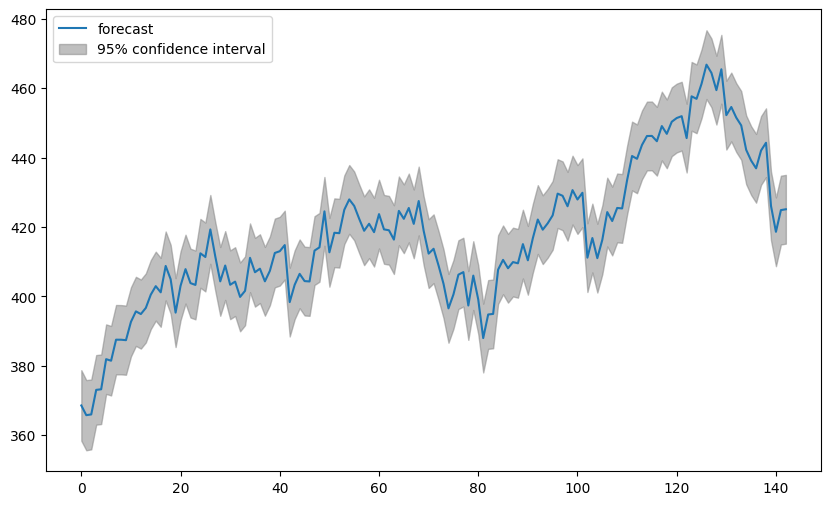

In [184]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(modelo1, 2, ax=ax);
plt.show();

En el gráfico anterior vemos el intervalo en el cual se encontrarían las predicciones del modelo, vemos que el área gris esta bordeando a los valores observados de manera cercana, lo que puede indicar que el modelo puede estar ajustando bien.

### **Supuestos**

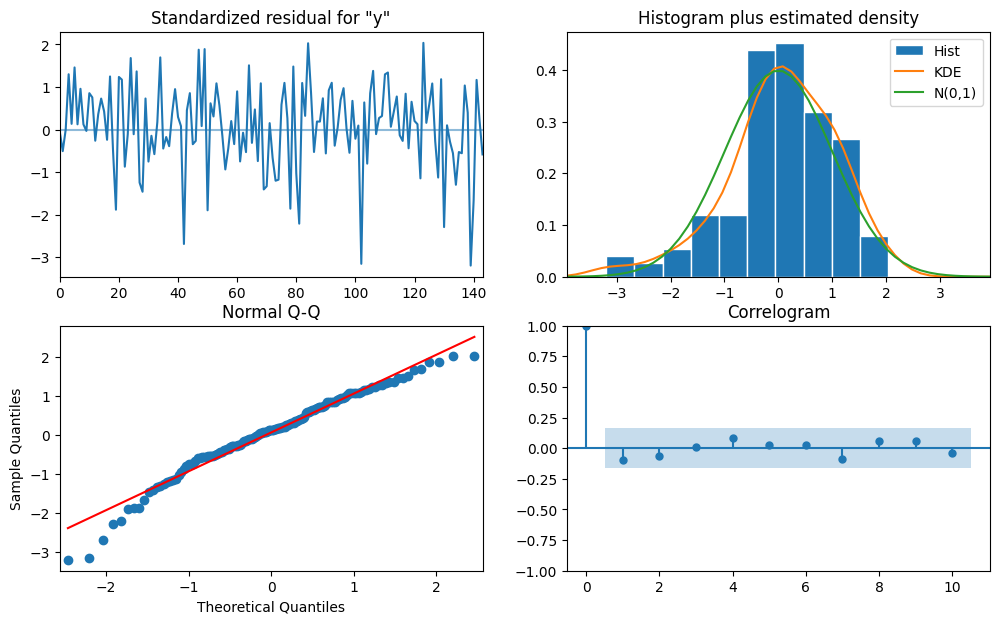

In [185]:
modelo1.plot_diagnostics(figsize=(12,7))
plt.show()

Lo mas importante al momento de revisar los residuos del modelo es poder determinar si son normales o no y si estos son independientes o no, los gráficos anteriores nos muestran que los residuos si se distribuyen normal, esto lo podemos ver en el histograma y en gráfico de Quantil Quantil por el lado de la independencia de los residuos vemos que los residuos no estan correlacionados entre si.

### **Predicciones**.

In [186]:
def arima_rolling(history, test, orden):
    
    predictions = list()
    for t in range(len(test)):
        model = smtsa.ARIMA(history, order=orden)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

#### **7 días**

Para hacer la predicción para los ultimos 7 días se necesita definir el conjunto de entrenamiento y test, esto se hará a continuación.

In [187]:
n = len(data['Adj Close']); n_test = 7
train_size = n - n_test

In [188]:
print('Tamaño de la muestra de entrenamiento', train_size)
print('Tamaño de la muestra de test', n_test)

Tamaño de la muestra de entrenamiento 138
Tamaño de la muestra de test 7


In [189]:
train_df7 = data[["Adj Close"]][:train_size]
test_df7 = data[["Adj Close"]][train_size:train_size + n_test] 

In [190]:
dates_train7 = data.index[:train_size]
dates_test7 = data.index[train_size:train_size + n_test]

##### **Rolling**

Primeramente se hará la predicción usando rolling.

In [191]:
test_final7 = test_df7['Adj Close'].tolist()
predic_7  = arima_rolling(train_df7['Adj Close'].tolist(), test_final7, (2,1,2))

predicted=436.753376, expected=442.143066
predicted=441.610326, expected=444.049652
predicted=444.408723, expected=428.128326
predicted=429.249566, expected=417.647217
predicted=418.545875, expected=424.504852
predicted=424.798157, expected=425.962250
predicted=425.144586, expected=422.159119


Vemos que la diferencia entre lo observado y lo predicho no es mucha lo que quiere decir que la predicción parece estar funcionando bien.

##### **Sin rolling**

Ahora veamos las mismas predicciónes pero sin utilizar el rolling.

In [192]:
modelo1=smtsa.ARIMA(train_df7['Adj Close'].tolist(), order=(2, 1, 2)).fit()
forecast_steps = len(test_df7)
forecast_7 = modelo1.forecast(steps=forecast_steps)

In [193]:
for i in range(len(test_df7)):
    observado = test_df7.iloc[i]['Adj Close'] 
    predicho_7 = forecast_7[i]

    print(f'observado: {observado}, predicho: {predicho_7}')

observado: 442.14306640625, predicho: 436.75337597708096
observado: 444.0496520996094, predicho: 436.0421349266471
observado: 428.1283264160156, predicho: 436.75785653230463
observado: 417.647216796875, predicho: 436.27517368579663
observado: 424.5048522949219, predicho: 436.39949441985107
observado: 425.9622497558594, predicho: 436.6217575551293
observado: 422.15911865234375, predicho: 436.17764635767463


Al hacer las predicciones sin el rolling vemos que hay un pequeño problema, puesto que el valor que esta prediciendo esta siempre cercano a 436 lo que quiere decir que no se esta capturando bien la varianza de los datos y esto ocurre por como se estan haciendo las predicciones.

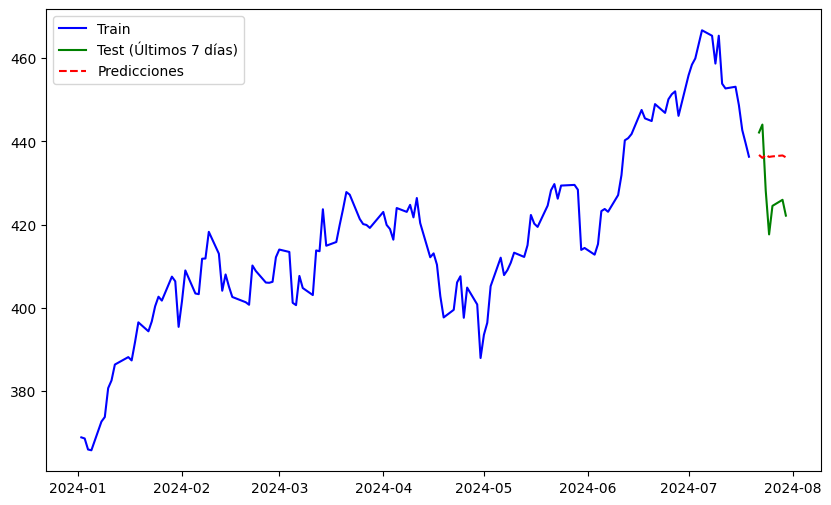

In [194]:
predicciones_df = pd.DataFrame({
    'Fecha': test_df7.index,
    'Predicho': forecast_7[:len(test_df7)]
})
plt.figure(figsize=(10, 6))
plt.plot(train_df7.index, train_df7['Adj Close'], label='Train', color='blue')
plt.plot(test_df7.index, test_df7['Adj Close'], label='Test (Últimos 7 días)', color='green')
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicho'], label='Predicciones', color='red', linestyle='dashed')
plt.legend()
plt.show()

Mediante esta gráfica podemos ver como esta prediciendo el modelo y confirmamos lo dicho anteriormente, donde no se esta capturando bien la variabilidad de los datos, mas adelante veremos que esto no ocurre cuando se usa el rolling.

#### **14 días**

Para encargarnos de hacer las predicciones para el horizonte de 14 días debemos separar de nuevo los conjunto de entrenamiento y test.

In [195]:
n = len(data['Adj Close']); n_test = 14
train_size = n - n_test

In [196]:
print('Tamaño de la muestra de entrenamiento', train_size)
print('Tamaño de la muestra de test', n_test)

Tamaño de la muestra de entrenamiento 131
Tamaño de la muestra de test 14


In [197]:
train_df14 = data[["Adj Close"]][:train_size]
test_df14 = data[["Adj Close"]][train_size:train_size + n_test] 

In [198]:
dates_train14 = data.index[:train_size]
dates_test14 = data.index[train_size:train_size + n_test]

##### **Rolling**

Como en el caso anterior, se harán primero las predicciones usando el rolling.

In [199]:
test_final14 = test_df14['Adj Close'].tolist()
predic_14  = arima_rolling(train_df14['Adj Close'].tolist(), test_final14, (2,1,2))

predicted=465.616129, expected=453.881927
predicted=453.442597, expected=452.733978
predicted=454.373398, expected=453.143250
predicted=451.062743, expected=448.711243
predicted=450.467532, expected=442.722015
predicted=441.877775, expected=439.577698
predicted=439.669304, expected=436.323547
predicted=436.753376, expected=442.143066
predicted=441.610326, expected=444.049652
predicted=444.408723, expected=428.128326
predicted=429.249566, expected=417.647217
predicted=418.545875, expected=424.504852
predicted=424.798157, expected=425.962250
predicted=425.144586, expected=422.159119


##### **Sin rolling**

Y ahora se harán las predicciones sin usar el rolling para predecir los ultimos 14 días.

In [200]:
modelo1=smtsa.ARIMA(train_df14['Adj Close'].tolist(), order=(2, 1, 2)).fit()
forecast_steps = len(test_df14)
forecast_14 = modelo1.forecast(steps=forecast_steps)

In [201]:
for i in range(len(test_df14)):
    observado = test_df14.iloc[i]['Adj Close']  # Valores observados
    predicho_14 = forecast_14[i]  # Predicciones ya alineadas con el test set

    print(f'observado: {observado}, predicho: {predicho_14}')

observado: 453.8819274902344, predicho: 465.61612880846985
observado: 452.7339782714844, predicho: 465.27813972989344
observado: 453.14324951171875, predicho: 465.6396623132482
observado: 448.71124267578125, predicho: 465.3538970861588
observado: 442.7220153808594, predicho: 465.4995603600402
observado: 439.57769775390625, predicho: 465.5115897252685
observado: 436.32354736328125, predicho: 465.3686844873118
observado: 442.14306640625, predicho: 465.58499938942975
observado: 444.0496520996094, predicho: 465.3635753203669
observado: 428.1283264160156, predicho: 465.5306895316434
observado: 417.647216796875, predicho: 465.4540140106438
observado: 424.5048522949219, predicho: 465.43349238979346
observado: 425.9622497558594, predicho: 465.53121012478755
observado: 422.15911865234375, predicho: 465.39374875938705


Vemos que el comportamiento de esta predicción es igual a la anterior, el modelo parece no captar de una buena manera la variabilidad de los datos, todos los valores estan cerca de 465, veremos este comportamiento gráficamente. Adémas vemos que los errores son mucho mas grandes y significativos.

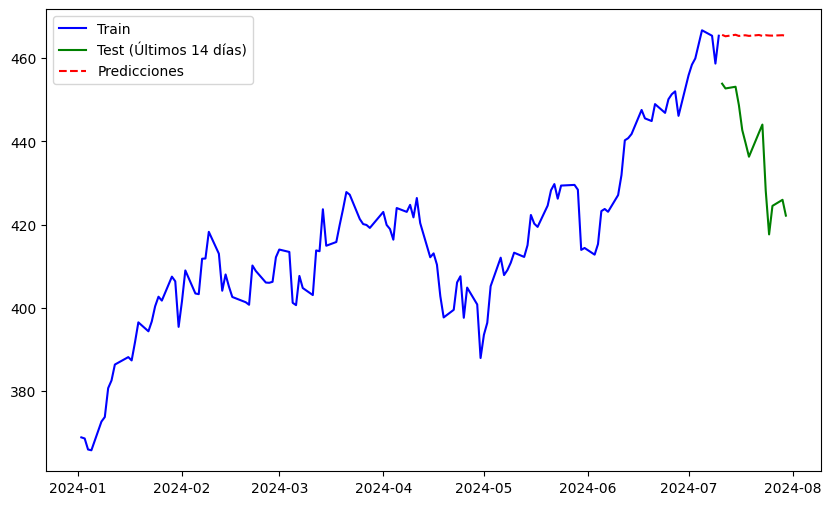

In [202]:
predicciones_df = pd.DataFrame({
    'Fecha': test_df14.index,
    'Predicho': forecast_14[:len(test_df14)]
})
plt.figure(figsize=(10, 6))
plt.plot(train_df14.index, train_df14['Adj Close'], label='Train', color='blue')
plt.plot(test_df14.index, test_df14['Adj Close'], label='Test (Últimos 14 días)', color='green')
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicho'], label='Predicciones', color='red', linestyle='dashed')
plt.legend()
plt.show()


Vemos que el modelo no esta ajustando nada en el conjunto del test, esto se verá en las tablas de error que se presentarán mas adelante.

#### **21 días**

Pasemos a hacer la predicción para el horizonre de 21 días siguiendo los mismos pasos utilizados anteriormente.

In [203]:
n = len(data['Adj Close']); n_test = 21
train_size = n - n_test

In [204]:
print('Tamaño de la muestra de entrenamiento', train_size)
print('Tamaño de la muestra de test', n_test)

Tamaño de la muestra de entrenamiento 124
Tamaño de la muestra de test 21


In [205]:
train_df21 = data[["Adj Close"]][:train_size]
test_df21 = data[["Adj Close"]][train_size:train_size + n_test] 

In [206]:
dates_train21 = data.index[:train_size]
dates_test21 = data.index[train_size:train_size + n_test]

##### **Rolling**

Rolling para predecir los ultimos 21 días.

In [207]:
test_final21 = test_df21['Adj Close'].tolist()
predic_21  = arima_rolling(train_df21['Adj Close'].tolist(), test_final21, (2,1,2))

predicted=446.024450, expected=455.908264
predicted=456.485008, expected=458.453674
predicted=456.490286, expected=459.940979
predicted=460.482912, expected=466.718781


c:\Users\fonta\miniconda3\envs\tarea1_venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=465.764440, expected=465.401154


c:\Users\fonta\miniconda3\envs\tarea1_venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=466.080622, expected=458.713226


c:\Users\fonta\miniconda3\envs\tarea1_venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=457.884010, expected=465.411133
predicted=465.616129, expected=453.881927
predicted=453.442597, expected=452.733978
predicted=454.373398, expected=453.143250
predicted=451.062743, expected=448.711243
predicted=450.467532, expected=442.722015
predicted=441.877775, expected=439.577698
predicted=439.669304, expected=436.323547
predicted=436.753376, expected=442.143066
predicted=441.610326, expected=444.049652
predicted=444.408723, expected=428.128326
predicted=429.249566, expected=417.647217
predicted=418.545875, expected=424.504852
predicted=424.798157, expected=425.962250
predicted=425.144586, expected=422.159119


##### **Sin Rolling**

Predicciones para los ultimos 21 días sin usar el rolling.

In [208]:
modelo1=smtsa.ARIMA(train_df21['Adj Close'].tolist(), order=(2, 1, 2)).fit()
forecast_steps = len(test_df21)
forecast_21 = modelo1.forecast(steps=forecast_steps)

In [209]:
for i in range(len(test_df21)):
    observado = test_df21.iloc[i]['Adj Close']  # Valores observados
    predicho_21 = forecast_21[i]  # Predicciones ya alineadas con el test set

    print(f'observado: {observado}, predicho: {predicho_21}')

observado: 455.90826416015625, predicho: 446.0244504062709
observado: 458.45367431640625, predicho: 446.947646833971
observado: 459.94097900390625, predicho: 446.4145749752134
observado: 466.7187805175781, predicho: 446.52824777093633
observado: 465.4011535644531, predicho: 446.580517888722
observado: 458.7132263183594, predicho: 446.5229034751384
observado: 465.4111328125, predicho: 446.5460006856757
observado: 453.8819274902344, predicho: 446.54508369908626
observado: 452.7339782714844, predicho: 446.54038447779783
observado: 453.14324951171875, predicho: 446.543447227743
observado: 448.71124267578125, predicho: 446.54265645080096
observado: 442.7220153808594, predicho: 446.54243975000054
observado: 439.57769775390625, predicho: 446.54275131775756
observado: 436.32354736328125, predicho: 446.54261140078586
observado: 442.14306640625, predicho: 446.54262547701586
observado: 444.0496520996094, predicho: 446.5426487682393
observado: 428.1283264160156, predicho: 446.5426314190232
observa

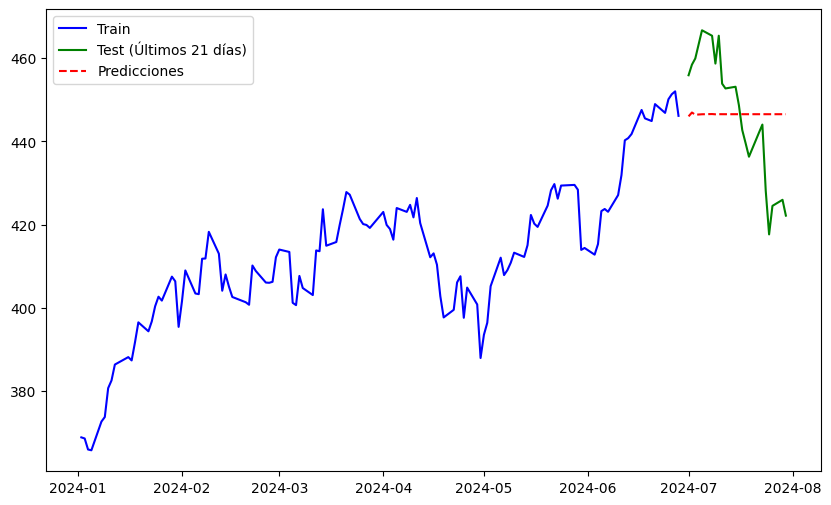

In [210]:
predicciones_df = pd.DataFrame({
    'Fecha': test_df21.index,
    'Predicho': forecast_21[:len(test_df21)]
})
plt.figure(figsize=(10, 6))
plt.plot(train_df21.index, train_df21['Adj Close'], label='Train', color='blue')
plt.plot(test_df21.index, test_df21['Adj Close'], label='Test (Últimos 21 días)', color='green')
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicho'], label='Predicciones', color='red', linestyle='dashed')
plt.legend()
plt.show()

Como era de esperarse, vemos que de igual forma que las predicciones anteriores el modelo no está prediciendo de la mejor manera los datos del test al momento de no usar rolling, las predicciones siempre estan al rededor de 446 y con diferencias significativas entre lo observado y predicho.

#### **28 días**

Este es el último horizonte de predicción, se dividirá de igual manera el conjunto de entrenamiento y test.

In [211]:
n = len(data['Adj Close']); n_test = 28
train_size = n - n_test

In [212]:
print('Tamaño de la muestra de entrenamiento', train_size)
print('Tamaño de la muestra de test', n_test)

Tamaño de la muestra de entrenamiento 117
Tamaño de la muestra de test 28


In [213]:
train_df28 = data[["Adj Close"]][:train_size]
test_df28 = data[["Adj Close"]][train_size:train_size + n_test] 

In [214]:
dates_train28 = data.index[:train_size]
dates_test28 = data.index[train_size:train_size + n_test]

##### **Rolling**

In [215]:
test_final28 = test_df28['Adj Close'].tolist()
predic_28  = arima_rolling(train_df28['Adj Close'].tolist(), test_final28,(2,1,2))

predicted=444.911769, expected=444.898132
predicted=445.607326, expected=448.970764
predicted=448.443134, expected=446.864594
predicted=447.286841, expected=450.138672
predicted=450.222666, expected=451.346497
predicted=450.812507, expected=452.035248
predicted=452.759397, expected=446.145874
predicted=446.024450, expected=455.908264
predicted=456.485008, expected=458.453674
predicted=456.490286, expected=459.940979
predicted=460.482912, expected=466.718781


c:\Users\fonta\miniconda3\envs\tarea1_venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=465.764440, expected=465.401154


c:\Users\fonta\miniconda3\envs\tarea1_venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=466.080622, expected=458.713226


c:\Users\fonta\miniconda3\envs\tarea1_venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=457.884010, expected=465.411133
predicted=465.616129, expected=453.881927
predicted=453.442597, expected=452.733978
predicted=454.373398, expected=453.143250
predicted=451.062743, expected=448.711243
predicted=450.467532, expected=442.722015
predicted=441.877775, expected=439.577698
predicted=439.669304, expected=436.323547
predicted=436.753376, expected=442.143066
predicted=441.610326, expected=444.049652
predicted=444.408723, expected=428.128326
predicted=429.249566, expected=417.647217
predicted=418.545875, expected=424.504852
predicted=424.798157, expected=425.962250
predicted=425.144586, expected=422.159119


##### **Sin Rolling**

In [216]:
modelo1=smtsa.ARIMA(train_df28['Adj Close'].tolist(), order=(2, 1, 2)).fit()
forecast_steps = len(test_df28)
forecast_28 = modelo1.forecast(steps=forecast_steps)

In [217]:
for i in range(len(test_df28)):
    observado = test_df28.iloc[i]['Adj Close']  # Valores observados
    predicho_28 = forecast_28[i]  # Predicciones ya alineadas con el test set

    print(f'observado: {observado}, predicho: {predicho_28}')

observado: 444.89813232421875, predicho: 444.9117694262907
observado: 448.97076416015625, predicho: 445.620264761318
observado: 446.8645935058594, predicho: 445.3265104806404
observado: 450.138671875, predicho: 445.34863539940915
observado: 451.34649658203125, predicho: 445.40029858468216
observado: 452.0352478027344, predicho: 445.3638563324359
observado: 446.1458740234375, predicho: 445.37463862523174
observado: 455.90826416015625, predicho: 445.3761418778194
observado: 458.45367431640625, predicho: 445.3728323387312
observado: 459.94097900390625, predicho: 445.374518913827
observado: 466.7187805175781, predicho: 445.3742236712287
observado: 465.4011535644531, predicho: 445.3740297231914
observado: 458.7132263183594, predicho: 445.3742136022874
observado: 465.4111328125, predicho: 445.37414439316996
observado: 453.8819274902344, predicho: 445.37414584422726
observado: 452.7339782714844, predicho: 445.3741603121828
observado: 453.14324951171875, predicho: 445.37415115938194
observado:

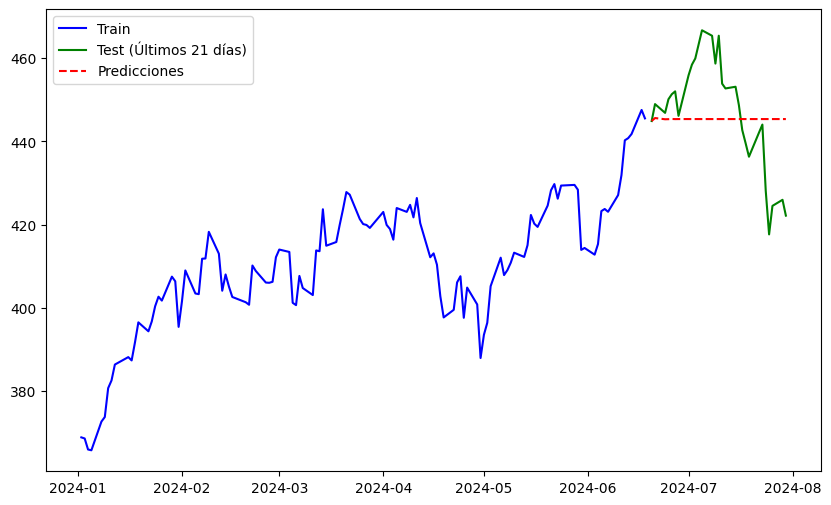

In [218]:
predicciones_df = pd.DataFrame({
    'Fecha': test_df28.index,
    'Predicho': forecast_28[:len(test_df28)]
})
plt.figure(figsize=(10, 6))
plt.plot(train_df28.index, train_df28['Adj Close'], label='Train', color='blue')
plt.plot(test_df28.index, test_df28['Adj Close'], label='Test (Últimos 21 días)', color='green')
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicho'], label='Predicciones', color='red', linestyle='dashed')
plt.legend()
plt.show()

Vemos que el mismo comportamiento de las predicciones anteriores se presenta en esta, el error en el conjunto de test es bastante grande, problema que ocuerre al hacer la predicción sin el rolling.

### **Gráficas de predicción con rolling**

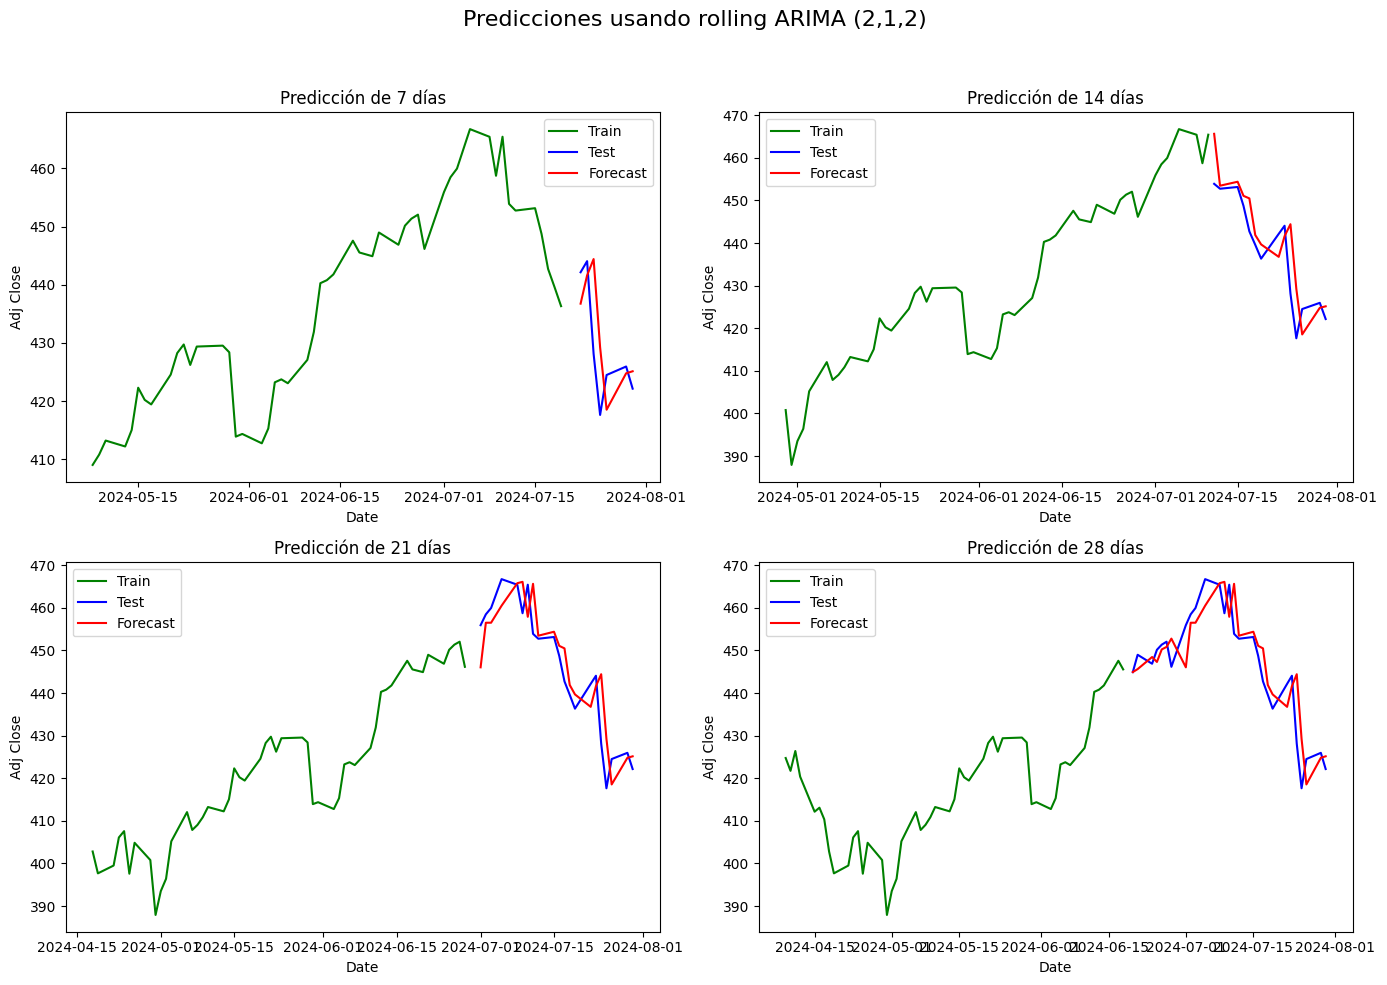

In [219]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfica para horizonte de 7 días
sns.lineplot(x=dates_train7[-50:], y=train_df7[-50:]['Adj Close'], label="Train", color='g', ax=axes[0, 0])
sns.lineplot(x=dates_test7[:7], y=test_final7[:7], label="Test", color='b', ax=axes[0, 0])
sns.lineplot(x=dates_test7[:7], y=predic_7, label="Forecast", color='r', ax=axes[0, 0])
axes[0, 0].set_title("Predicción de 7 días")

# Gráfica para horizonte de 14 días
sns.lineplot(x=dates_train14[-50:], y=train_df14[-50:]['Adj Close'], label="Train", color='g', ax=axes[0, 1])
sns.lineplot(x=dates_test14[:14], y=test_final14[:14], label="Test", color='b', ax=axes[0, 1])
sns.lineplot(x=dates_test14[:14], y=predic_14, label="Forecast", color='r', ax=axes[0, 1])
axes[0, 1].set_title("Predicción de 14 días")

# Gráfica para horizonte de 21 días
sns.lineplot(x=dates_train21[-50:], y=train_df21[-50:]['Adj Close'], label="Train", color='g', ax=axes[1, 0])
sns.lineplot(x=dates_test21[:21], y=test_final21[:21], label="Test", color='b', ax=axes[1, 0])
sns.lineplot(x=dates_test21[:21], y=predic_21, label="Forecast", color='r', ax=axes[1, 0])
axes[1, 0].set_title("Predicción de 21 días")

# Gráfica para horizonte de 28 días
sns.lineplot(x=dates_train28[-50:], y=train_df28[-50:]['Adj Close'], label="Train", color='g', ax=axes[1, 1])
sns.lineplot(x=dates_test28, y=test_final28, label="Test", color='b', ax=axes[1, 1])
sns.lineplot(x=dates_test28, y=predic_28, label="Forecast", color='r', ax=axes[1, 1])
axes[1, 1].set_title("Predicción de 28 días")

fig.suptitle("Predicciones usando rolling ARIMA (2,1,2)", fontsize=16)

# Ajustar la presentación
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Esta última gráfica muestra las predicciones de cada uno de los horizontes establecidos para este ejercicio usando el método de rolling, vemos que a diferencia de lo que se notó en las gráficas de las predicciones sin el uso del rolling estas predicciones siguen de mejor forma la variabilidad de los datos del test, es por esto que se esperaría que los errores de las predicciones con rolling sean menores que los errores al no implementar el rolling.

### **Tablas de errores**

In [220]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) 
    mae = np.mean(np.abs(forecast - actual))                 
    rmse = np.mean((forecast - actual)**2)**.5               
    mse = np.mean((forecast - actual)**2)                    
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

**Errores de predicción sin rolling**

In [221]:
d7=forecast_accuracy(np.array(test_df7), np.array(forecast_7), " 7 días")
d14=forecast_accuracy(np.array(test_df14), np.array(forecast_14), " 14 días ")
d21=forecast_accuracy(np.array(test_df21), np.array(forecast_21), " 21 días")
d28=forecast_accuracy(np.array(test_df28), np.array(forecast_28), " 28 días")

errores_sin = pd.concat([d7, d14, d21, d28])
errores_sin

,MAE,MSE,MAPE,RMSE,R2
7 días,11.012633,138.369859,0.025233,11.763072,-0.597802
14 días,27.490804,897.496157,0.059060,29.958240,-5.330216
21 días,12.822302,223.212533,0.028715,14.940299,-0.003073
28 días,10.507741,171.436241,0.023594,13.093366,-0.007390


En la tabla anterior se presentan las métricas de error para las predicciones del modelo que se hicieron sin usar el método de Rolling, vemos que el comportamiento era lo que esperábamos al ver las gráficas de cada uno de los horizontes, el $R^{2}$ que es el que indica que también ajusta el modelo tiene la misma interpretación en las 4 predicciones y es que el modelo no ajusto para nada bien. Por parte los otros errores, el MSE es mínimo en la predicción de los 7 días, lo que indica que los errores o la diferencia entre lo observado y predicho es menor en ese horizonte de predicción.

Veamos que pasa con los errores al usar el Rolling.

**Errores de predicción con rolling**

In [222]:
d7=forecast_accuracy(np.array(test_df7), np.array(predic_7), " 7 días")
d14=forecast_accuracy(np.array(test_df14), np.array(predic_14), " 14 días ")
d21=forecast_accuracy(np.array(test_df21), np.array(predic_21), " 21 días")
d28=forecast_accuracy(np.array(test_df28), np.array(predic_28), " 28 días")

errores_rolinAIC = pd.concat([d7, d14, d21, d28])
errores_rolinAIC

,MAE,MSE,MAPE,RMSE,R2
7 días,10.429620,170.795290,0.024080,13.068867,0.205547
14 días,14.335550,317.838622,0.032432,17.828029,0.646157
21 días,16.358713,413.723698,0.036754,20.340199,0.793520
28 días,13.962561,315.340071,0.031359,17.757817,0.782878


Esta tabla de errores es mucho mas optimista, esta tabla contiene los errores obtenidos en la predicciones donde se usó el rolling, empezando por el $R^{2}$ en este punto ninguno es negativo lo que da mas tranquilidad, el $R^2$  mas alto se obtuvo en la prediccion de los 21 días donde es de 79%. Por parte del MSE, se obtuvo el minimo en la predicción de los 7 días es decir que la diferencia entre lo observado y predicho es menor en ese forecast y de hecho si nos fijamos bien todos los errores son mínimos en la predicción de los 7 días.

Pasemos a analisar los gráficos de corelación de lo observado vs lo predicho, esta vez se harán solamente para las predicciones con rolling puesto que estas fueron las predicciones que tucieron mejor ajuste.

### **Gráficos de correlación: observado vs predicho**

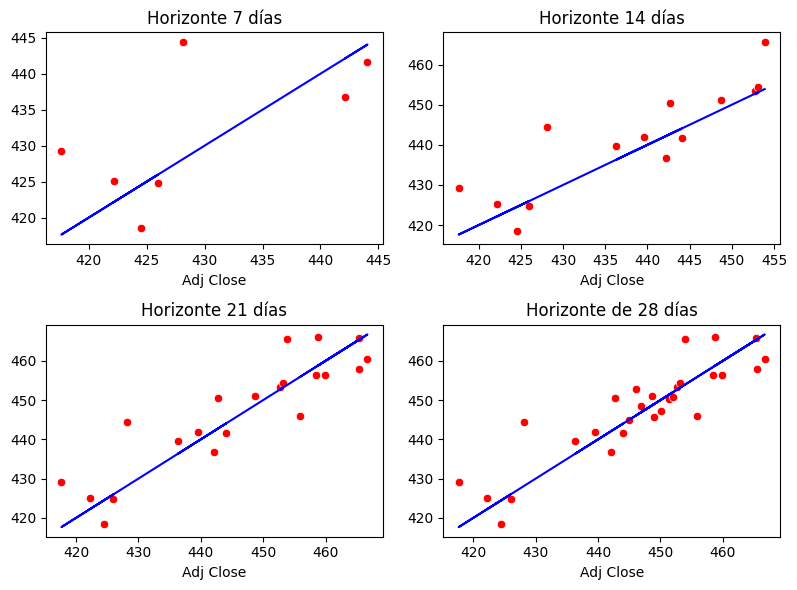

In [223]:
plt.rcParams.update({'figure.figsize' : (8 , 6)})
fig , axes = plt.subplots(nrows = 2 , ncols = 2)

# Horizonte de 7 días
sns.scatterplot(x = test_df7['Adj Close'] , y = predic_7 , ax = axes[0 , 0] , color = 'r')
axes[0 , 0].plot(test_df7 , test_df7 , color = 'b' , label = 'Correlación')
axes[0 , 0].set_title('Horizonte 7 días' , fontsize = 12)

# Horizonte de 14 días
sns.scatterplot(x = test_df14['Adj Close'] , y = predic_14 , ax = axes[0 , 1] , color = 'r')
axes[0 , 1].plot(test_df14 , test_df14 , color = 'b' , label = 'Correlación')
axes[0 , 1].set_title('Horizonte 14 días' , fontsize = 12)

# Horizonte de 21 días
sns.scatterplot(x = test_df21['Adj Close'] , y = predic_21 , ax = axes[1 , 0] , color = 'r' )
axes[1 , 0].plot(test_df21 , test_df21 , color = 'b' , label = 'Correlación')
axes[1 , 0].set_title('Horizonte 21 días' , fontsize = 12)

# Horizonte de 28 días
sns.scatterplot(x = test_df28['Adj Close'] , y = predic_28 , ax = axes[1 , 1] , color = 'r' )
axes[1 , 1].plot(test_df28 , test_df28 , color = 'b' , label = 'Correlación')
axes[1 , 1].set_title('Horizonte de 28 días' , fontsize = 12)

plt.tight_layout()
plt.show()

El gráfico anterior muestra como son las correlaciones entre los valores observados y predichos, lo ideal seria que en cada uno de los horizontes los puntos estuvieran sobre la linea azul, es decir, que tuvieran correlación de 1, pero como hablamos anteriormente esto no ocurre, las correlaciones mas altas estan en los días 21 y 28 que como vimos en la table de errores, estas correlaciones son de 79% y 78% respectivamente.

## **Análisis de los supuestos y predicciones: modelo 2 BIC**

Ahora veamos como se comporta el modelo dos que es el que obtuvo el menor BIC.

In [224]:
modelo2=smtsa.ARIMA(data['Adj Close'].tolist(), order=(1, 1, 1)).fit()

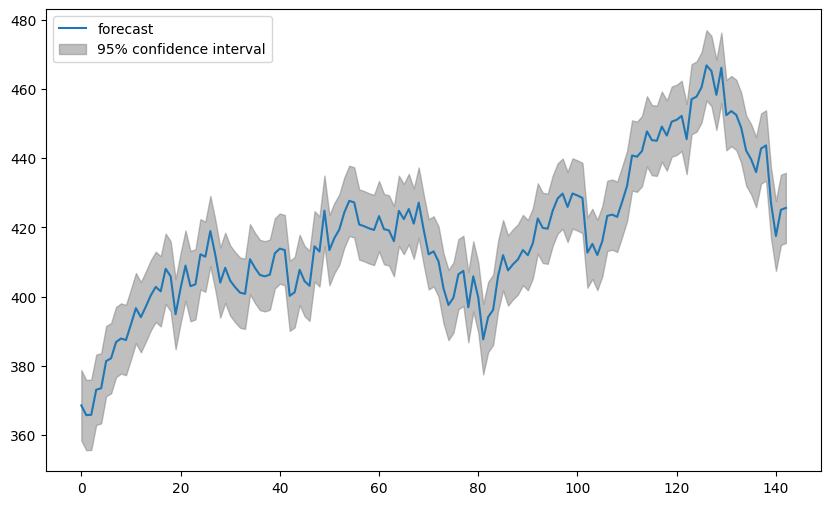

In [225]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(modelo2, 2, ax=ax);
plt.show();

### **Supuestos**

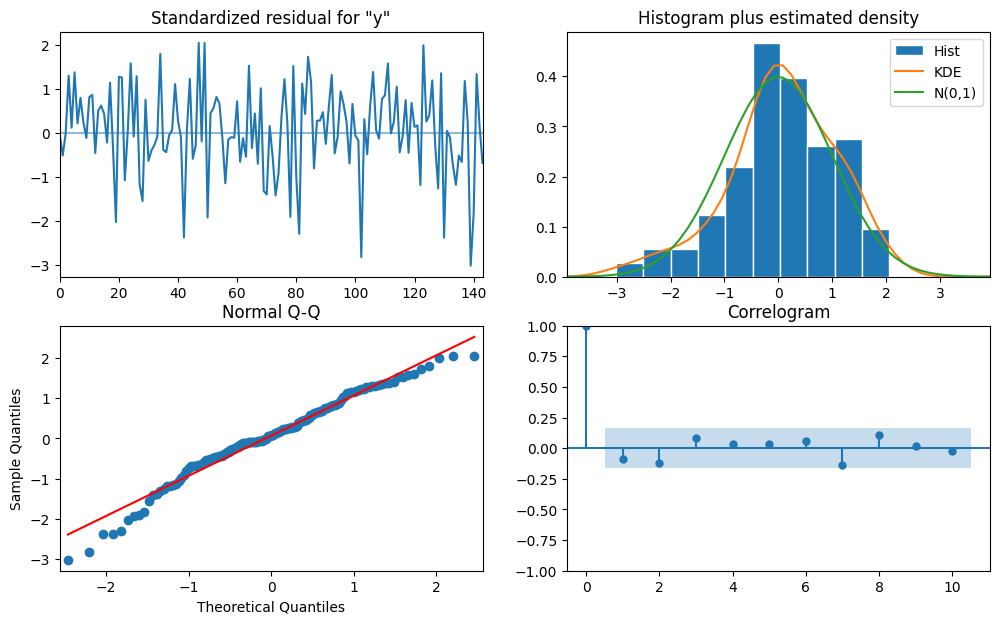

In [226]:
modelo2.plot_diagnostics(figsize=(12,7))
plt.show()

Si vemos los residuos del nuestro segundo modelo, vemos que estos de igual forma con indepentientes, es decir, que lo residuos no siguen una tendencia, lo cual es lo ideal, vemos ademas que estos siguen una distribución normal.

### **Predicciones**

A continuación pasaremos a hacer las predicciones para cada uno de los horizontes de predicción.

Recordemos que para cada una de las predicciones se debe separar cada uno de los conjuntos de entrenamiento y de test, este proceso ya se realizó en las predicciones del modelo anterior, por tanto en esta seccion solo pasaremos a predecir con el nuevo modelo y utilizando los conjuntos anteriormente definidos.

#### **7 días**

##### **Rolling**

Predicciones usando el rolling para los ultimos 7 días.

In [227]:
predic_7  = arima_rolling(train_df7['Adj Close'].tolist(), test_final7, (1,1,1))

predicted=436.106540, expected=442.143066
predicted=442.512781, expected=444.049652
predicted=443.853300, expected=428.128326
predicted=427.555598, expected=417.647217
predicted=417.539112, expected=424.504852
predicted=425.079326, expected=425.962250
predicted=425.662099, expected=422.159119


##### **Sin Rolling**

In [228]:
modelo2=smtsa.ARIMA(train_df7['Adj Close'].tolist(), order=(1, 1, 1)).fit()
forecast_steps = len(test_df7)
forecast_7 = modelo2.forecast(steps=forecast_steps)

In [229]:
for i in range(len(test_df7)):
    observado = test_df7.iloc[i]['Adj Close'] 
    predicho_7 = forecast_7[i]

    print(f'observado: {observado}, predicho: {predicho_7}')

observado: 442.14306640625, predicho: 436.10653994363116
observado: 444.0496520996094, predicho: 436.2543278799304
observado: 428.1283264160156, predicho: 436.1536802884757
observado: 417.647216796875, predicho: 436.22222402701954
observado: 424.5048522949219, predicho: 436.17554388270946
observado: 425.9622497558594, predicho: 436.20733432657937
observado: 422.15911865234375, predicho: 436.18568417239965


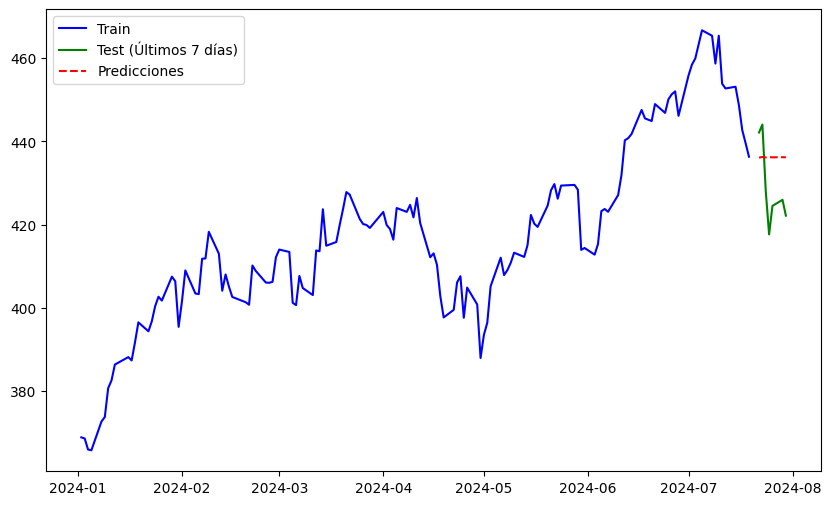

In [230]:
predicciones_df = pd.DataFrame({
    'Fecha': test_df7.index,
    'Predicho': forecast_7[:len(test_df7)]
})
plt.figure(figsize=(10, 6))
plt.plot(train_df7.index, train_df7['Adj Close'], label='Train', color='blue')
plt.plot(test_df7.index, test_df7['Adj Close'], label='Test (Últimos 7 días)', color='green')
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicho'], label='Predicciones', color='red', linestyle='dashed')
plt.legend()
plt.show()

En la gráfica anterior vemos como fueron las predicciones de los ultimos 7 días sin usar el rolling, vemos que de igual forma que con los modelos anteriores las predicciones no estan ajustando bien en el conjunto de test, veremos que este comportamiento se repite en las demas predicciones.

#### **14 días**

##### **Rolling**

In [231]:
predic_14  = arima_rolling(train_df14['Adj Close'].tolist(), test_final14, (1,1,1))

predicted=466.043691, expected=453.881927
predicted=454.708970, expected=452.733978
predicted=453.114718, expected=453.143250
predicted=453.255447, expected=448.711243
predicted=448.877668, expected=442.722015
predicted=442.403026, expected=439.577698
predicted=439.698731, expected=436.323547
predicted=436.106540, expected=442.143066
predicted=442.512781, expected=444.049652
predicted=443.853300, expected=428.128326
predicted=427.555598, expected=417.647217
predicted=417.539112, expected=424.504852
predicted=425.079326, expected=425.962250
predicted=425.662099, expected=422.159119


##### **Sin rolling**

In [232]:
modelo2=smtsa.ARIMA(train_df14['Adj Close'].tolist(), order=(1, 1, 1)).fit()
forecast_steps = len(test_df14)
forecast_14 = modelo2.forecast(steps=forecast_steps)

In [233]:
for i in range(len(test_df14)):
    observado = test_df14.iloc[i]['Adj Close'] 
    predicho_14 = forecast_14[i]

    print(f'observado: {observado}, predicho: {predicho_14}')

observado: 453.8819274902344, predicho: 466.04369116862694
observado: 452.7339782714844, predicho: 465.599172359195
observado: 453.14324951171875, predicho: 465.91154981816754
observado: 448.71124267578125, predicho: 465.69203227514424
observado: 442.7220153808594, predicho: 465.8462942115
observado: 439.57769775390625, predicho: 465.73788945860196
observado: 436.32354736328125, predicho: 465.8140689149766
observado: 442.14306640625, predicho: 465.76053519603533
observado: 444.0496520996094, predicho: 465.798155037395
observado: 428.1283264160156, predicho: 465.77171838229395
observado: 417.647216796875, predicho: 465.79029625789553
observado: 424.5048522949219, predicho: 465.7772409957775
observado: 425.9622497558594, predicho: 465.78641534232963
observado: 422.15911865234375, predicho: 465.7799682381737


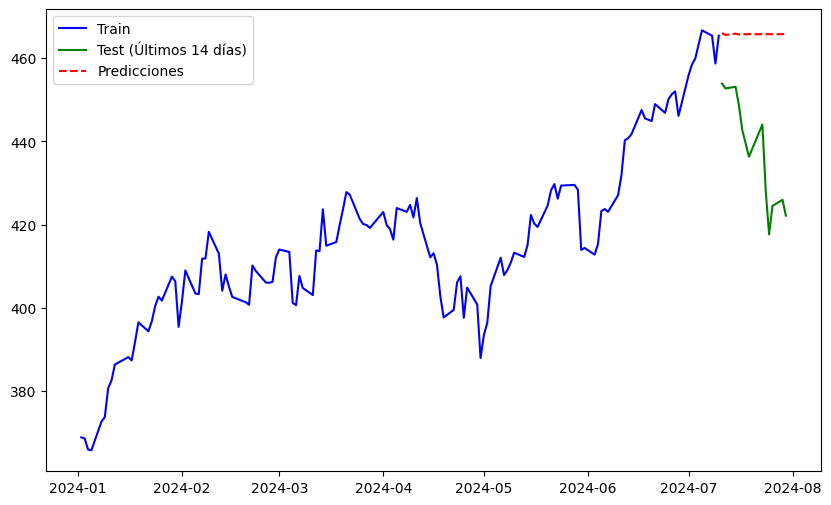

In [234]:
predicciones_df = pd.DataFrame({
    'Fecha': test_df14.index,
    'Predicho': forecast_14[:len(test_df14)]
})
plt.figure(figsize=(10, 6))
plt.plot(train_df14.index, train_df14['Adj Close'], label='Train', color='blue')
plt.plot(test_df14.index, test_df14['Adj Close'], label='Test (Últimos 14 días)', color='green')
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicho'], label='Predicciones', color='red', linestyle='dashed')
plt.legend()
plt.show()

#### **21 días**

##### **Rolling**

In [235]:
predic_21  = arima_rolling(train_df21['Adj Close'].tolist(), test_final21, (1,1,1))

predicted=445.373598, expected=455.908264
predicted=456.756582, expected=458.453674
predicted=457.726308, expected=459.940979
predicted=460.466867, expected=466.718781
predicted=466.233378, expected=465.401154
predicted=465.811057, expected=458.713226
predicted=458.331704, expected=465.411133
predicted=466.043691, expected=453.881927
predicted=454.708970, expected=452.733978
predicted=453.114718, expected=453.143250
predicted=453.255447, expected=448.711243
predicted=448.877668, expected=442.722015
predicted=442.403026, expected=439.577698
predicted=439.698731, expected=436.323547
predicted=436.106540, expected=442.143066
predicted=442.512781, expected=444.049652
predicted=443.853300, expected=428.128326
predicted=427.555598, expected=417.647217
predicted=417.539112, expected=424.504852
predicted=425.079326, expected=425.962250
predicted=425.662099, expected=422.159119


##### **Sin rolling**

In [236]:
modelo2=smtsa.ARIMA(train_df21['Adj Close'].tolist(), order=(1, 1, 1)).fit()
forecast_steps = len(test_df21)
forecast_21 = modelo2.forecast(steps=forecast_steps)

In [237]:
for i in range(len(test_df21)):
    observado = test_df21.iloc[i]['Adj Close'] 
    predicho_21 = forecast_21[i]

    print(f'observado: {observado}, predicho: {predicho_21}')

observado: 455.90826416015625, predicho: 445.3735983482845
observado: 458.45367431640625, predicho: 446.05423894749555
observado: 459.94097900390625, predicho: 445.4543603805543
observado: 466.7187805175781, predicho: 445.98305980796516
observado: 465.4011535644531, predicho: 445.5170936942401
observado: 458.7132263183594, predicho: 445.92777017294054
observado: 465.4111328125, predicho: 445.56582288709706
observado: 453.8819274902344, predicho: 445.8848229869908
observado: 452.7339782714844, predicho: 445.60367413545276
observado: 453.14324951171875, predicho: 445.8514630130973
observado: 448.71124267578125, predicho: 445.63307575115954
observado: 442.7220153808594, predicho: 445.82555007296946
observado: 439.57769775390625, predicho: 445.65591396769724
observado: 436.32354736328125, predicho: 445.8054217458847
observado: 442.14306640625, predicho: 445.67365394973854
observado: 444.0496520996094, predicho: 445.7897867176234
observado: 428.1283264160156, predicho: 445.68743378943424
ob

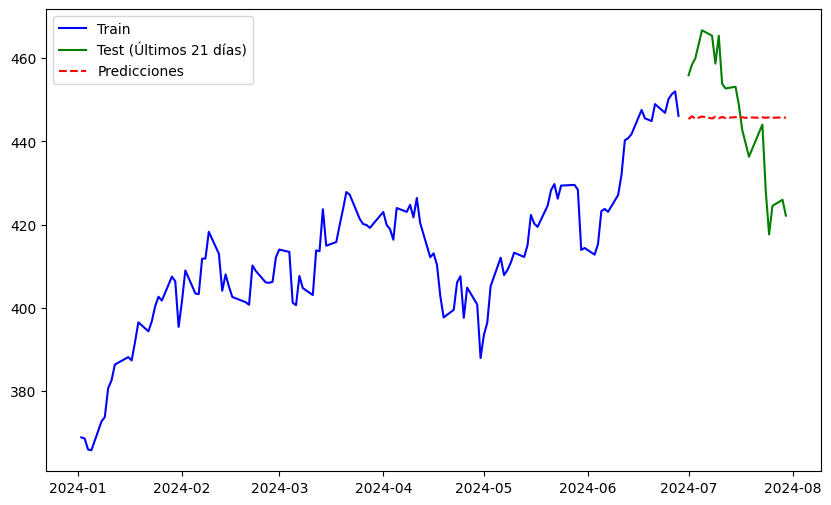

In [238]:
predicciones_df = pd.DataFrame({
    'Fecha': test_df21.index,
    'Predicho': forecast_21[:len(test_df21)]
})
plt.figure(figsize=(10, 6))
plt.plot(train_df21.index, train_df21['Adj Close'], label='Train', color='blue')
plt.plot(test_df21.index, test_df21['Adj Close'], label='Test (Últimos 21 días)', color='green')
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicho'], label='Predicciones', color='red', linestyle='dashed')
plt.legend()
plt.show()

#### **28 días**

##### **Rolling**

In [239]:
predic_28  = arima_rolling(train_df28['Adj Close'].tolist(), test_final28, (1,1,1))

predicted=446.037890, expected=444.898132
predicted=444.396204, expected=448.970764
predicted=449.625665, expected=446.864594
predicted=446.168217, expected=450.138672
predicted=450.903757, expected=451.346497
predicted=450.680234, expected=452.035248
predicted=452.675523, expected=446.145874
predicted=445.373598, expected=455.908264
predicted=456.756582, expected=458.453674
predicted=457.726308, expected=459.940979
predicted=460.466867, expected=466.718781
predicted=466.233378, expected=465.401154
predicted=465.811057, expected=458.713226
predicted=458.331704, expected=465.411133
predicted=466.043691, expected=453.881927
predicted=454.708970, expected=452.733978
predicted=453.114718, expected=453.143250
predicted=453.255447, expected=448.711243
predicted=448.877668, expected=442.722015
predicted=442.403026, expected=439.577698
predicted=439.698731, expected=436.323547
predicted=436.106540, expected=442.143066
predicted=442.512781, expected=444.049652
predicted=443.853300, expected=428

##### **Sin rolling**

In [240]:
modelo2=smtsa.ARIMA(train_df28['Adj Close'].tolist(), order=(1, 1, 1)).fit()
forecast_steps = len(test_df28)
forecast_28 = modelo2.forecast(steps=forecast_steps)

In [241]:
for i in range(len(test_df28)):
    observado = test_df28.iloc[i]['Adj Close'] 
    predicho_28 = forecast_28[i]

    print(f'observado: {observado}, predicho: {predicho_28}')

observado: 444.89813232421875, predicho: 446.03788973837635
observado: 448.97076416015625, predicho: 445.5893620830481
observado: 446.8645935058594, predicho: 445.99096684289754
observado: 450.138671875, predicho: 445.63137612152786
observado: 451.34649658203125, predicho: 445.95334811942854
observado: 452.0352478027344, predicho: 445.66505934757896
observado: 446.1458740234375, predicho: 445.92318867719905
observado: 455.90826416015625, predicho: 445.6920636480048
observado: 458.45367431640625, predicho: 445.8990094421874
observado: 459.94097900390625, predicho: 445.71371336292174
observado: 466.7187805175781, predicho: 445.8796246206346
observado: 465.4011535644531, predicho: 445.7310702338124
observado: 458.7132263183594, predicho: 445.86408354555715
observado: 465.4111328125, predicho: 445.7449854732634
observado: 453.8819274902344, predicho: 445.8516240543049
observado: 452.7339782714844, predicho: 445.75614150998217
observado: 453.14324951171875, predicho: 445.84163511071563
obse

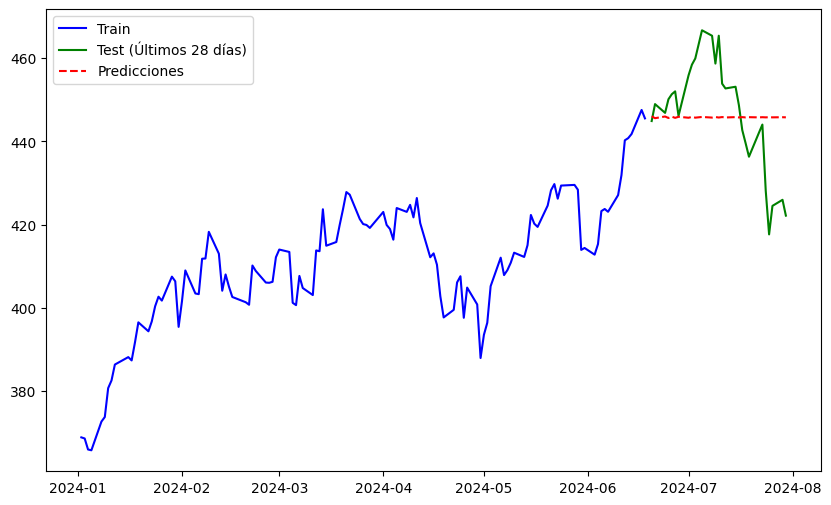

In [242]:
predicciones_df = pd.DataFrame({
    'Fecha': test_df28.index,
    'Predicho': forecast_28[:len(test_df28)]
})
plt.figure(figsize=(10, 6))
plt.plot(train_df28.index, train_df28['Adj Close'], label='Train', color='blue')
plt.plot(test_df28.index, test_df28['Adj Close'], label='Test (Últimos 28 días)', color='green')
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicho'], label='Predicciones', color='red', linestyle='dashed')
plt.legend()
plt.show()

### **Gráficas de predicción con rolling**

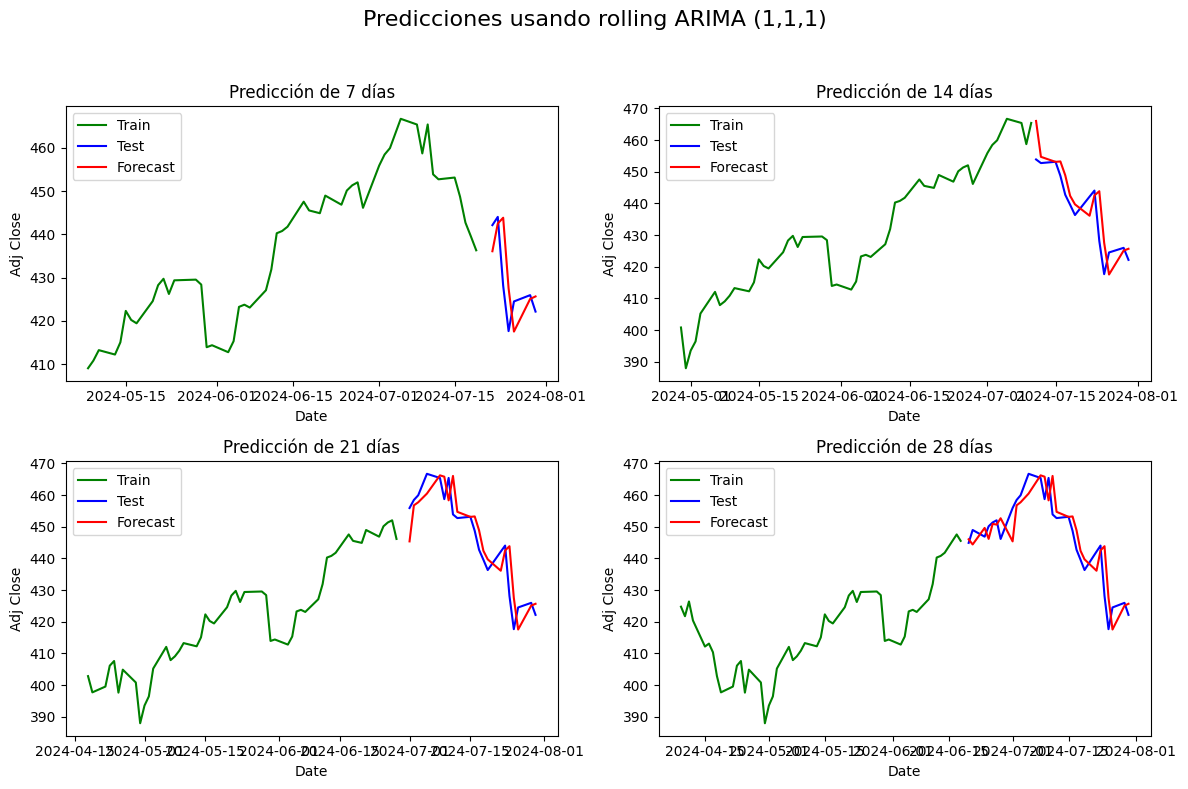

In [243]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Gráfica para horizonte de 7 días
sns.lineplot(x=dates_train7[-50:], y=train_df7[-50:]['Adj Close'], label="Train", color='g', ax=axes[0, 0])
sns.lineplot(x=dates_test7[:7], y=test_final7[:7], label="Test", color='b', ax=axes[0, 0])
sns.lineplot(x=dates_test7[:7], y=predic_7, label="Forecast", color='r', ax=axes[0, 0])
axes[0, 0].set_title("Predicción de 7 días")

# Gráfica para horizonte de 14 días
sns.lineplot(x=dates_train14[-50:], y=train_df14[-50:]['Adj Close'], label="Train", color='g', ax=axes[0, 1])
sns.lineplot(x=dates_test14[:14], y=test_final14[:14], label="Test", color='b', ax=axes[0, 1])
sns.lineplot(x=dates_test14[:14], y=predic_14, label="Forecast", color='r', ax=axes[0, 1])
axes[0, 1].set_title("Predicción de 14 días")

# Gráfica para horizonte de 21 días
sns.lineplot(x=dates_train21[-50:], y=train_df21[-50:]['Adj Close'], label="Train", color='g', ax=axes[1, 0])
sns.lineplot(x=dates_test21[:21], y=test_final21[:21], label="Test", color='b', ax=axes[1, 0])
sns.lineplot(x=dates_test21[:21], y=predic_21, label="Forecast", color='r', ax=axes[1, 0])
axes[1, 0].set_title("Predicción de 21 días")

# Gráfica para horizonte de 28 días
sns.lineplot(x=dates_train28[-50:], y=train_df28[-50:]['Adj Close'], label="Train", color='g', ax=axes[1, 1])
sns.lineplot(x=dates_test28, y=test_final28, label="Test", color='b', ax=axes[1, 1])
sns.lineplot(x=dates_test28, y=predic_28, label="Forecast", color='r', ax=axes[1, 1])
axes[1, 1].set_title("Predicción de 28 días")

fig.suptitle("Predicciones usando rolling ARIMA (1,1,1)", fontsize=16)

# Ajustar la presentación
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

La gráfica anterior muestra las predicciones del modelo en cada uno de los horizontes de predicción en los respectivos conjuntos de test, se nota un buen ajuste y esto se comprueba en las tablas de errores.

### **Tablas de errores**

**Errores de predicción sin rolling**

In [244]:
d7=forecast_accuracy(np.array(test_df7), np.array(forecast_7), " 7 días")
d14=forecast_accuracy(np.array(test_df14), np.array(forecast_14), " 14 días ")
d21=forecast_accuracy(np.array(test_df21), np.array(forecast_21), " 21 días")
d28=forecast_accuracy(np.array(test_df28), np.array(forecast_28), " 28 días")

errores_sin = pd.concat([d7, d14, d21, d28])
errores_sin

,MAE,MSE,MAPE,RMSE,R2
7 días,10.907198,134.817749,0.025006,11.611105,-0.561903
14 días,27.815778,915.467951,0.059717,30.256701,-5.456089
21 días,12.860680,222.722681,0.028853,14.923896,-0.001240
28 días,10.413227,170.609261,0.023358,13.061748,-0.004023


Como era de esperarse el ajuste del modelo al hacer las predicciones sin usar Rolling no es adecuado, puesto que el $R^2$ da en todos negativos, lo cual es preocupante al momento de evaluar los modelos ya que la correlación debería ser positiva.

**Errores de predicción con rolling**

In [245]:
d7=forecast_accuracy(np.array(test_df7), np.array(predic_7), " 7 días")
d14=forecast_accuracy(np.array(test_df14), np.array(predic_14), " 14 días ")
d21=forecast_accuracy(np.array(test_df21), np.array(predic_21), " 21 días")
d28=forecast_accuracy(np.array(test_df28), np.array(predic_28), " 28 días")

errores_rolinBIC = pd.concat([d7, d14, d21, d28])
errores_rolinBIC

,MAE,MSE,MAPE,RMSE,R2
7 días,10.399537,173.115101,0.024035,13.157321,0.262791
14 días,14.472146,325.634952,0.032747,18.045358,0.659565
21 días,16.490149,421.877817,0.037054,20.539664,0.800148
28 días,14.101503,321.774228,0.031674,17.938066,0.784798


Vemos que al momento de usar rolling el ajuste de las predicciones  mejora en gran manera, esto se puede ver al analizar los $R^2$, el mejor se obtuvo en el horizonte de 21 dias con un 80% de ajuste, a medida que se expande el horizonte de predicción los errores van aumentando poco a poco, es por esto que los errores mas pequeños al predecir los ultimos 7 días.

### **Gráficos de correlación: observado vs predicho**

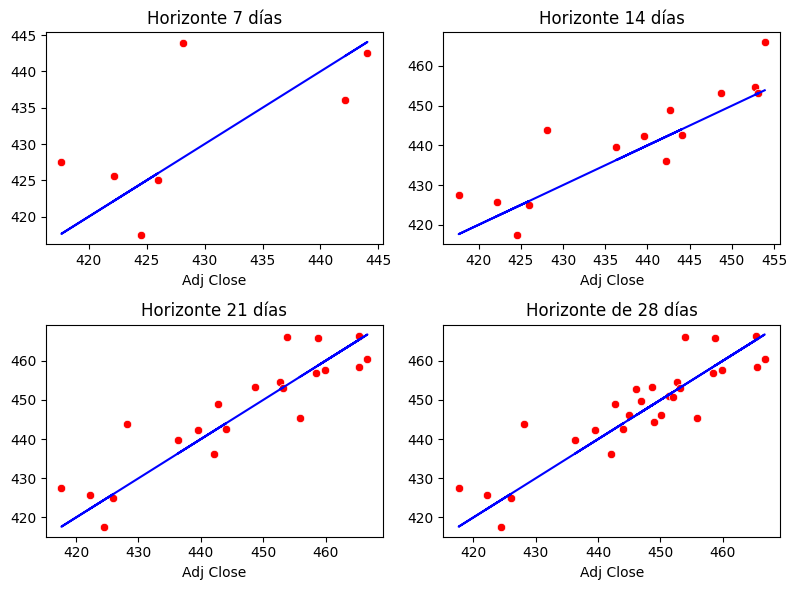

In [246]:
plt.rcParams.update({'figure.figsize' : (8 , 6)})
fig , axes = plt.subplots(nrows = 2 , ncols = 2)

# Horizonte de 7 días
sns.scatterplot(x = test_df7['Adj Close'] , y = predic_7 , ax = axes[0 , 0] , color = 'r')
axes[0 , 0].plot(test_df7 , test_df7 , color = 'b' , label = 'Correlación')
axes[0 , 0].set_title('Horizonte 7 días' , fontsize = 12)

# Horizonte de 14 días
sns.scatterplot(x = test_df14['Adj Close'] , y = predic_14 , ax = axes[0 , 1] , color = 'r')
axes[0 , 1].plot(test_df14 , test_df14 , color = 'b' , label = 'Correlación')
axes[0 , 1].set_title('Horizonte 14 días' , fontsize = 12)

# Horizonte de 21 días
sns.scatterplot(x = test_df21['Adj Close'] , y = predic_21 , ax = axes[1 , 0] , color = 'r' )
axes[1 , 0].plot(test_df21 , test_df21 , color = 'b' , label = 'Correlación')
axes[1 , 0].set_title('Horizonte 21 días' , fontsize = 12)

# Horizonte de 28 días
sns.scatterplot(x = test_df28['Adj Close'] , y = predic_28 , ax = axes[1 , 1] , color = 'r' )
axes[1 , 1].plot(test_df28 , test_df28 , color = 'b' , label = 'Correlación')
axes[1 , 1].set_title('Horizonte de 28 días' , fontsize = 12)

plt.tight_layout()
plt.show()

## **Comparación entre modelo 1 y modelo 2 mediante los errores**

**Errores de Rolling en el modelo 1: mejor AIC**

In [247]:
errores_rolinAIC

,MAE,MSE,MAPE,RMSE,R2
7 días,10.429620,170.795290,0.024080,13.068867,0.205547
14 días,14.335550,317.838622,0.032432,17.828029,0.646157
21 días,16.358713,413.723698,0.036754,20.340199,0.793520
28 días,13.962561,315.340071,0.031359,17.757817,0.782878


**Errores de Rolling en el modelo 2: mejor BIC**

In [248]:
errores_rolinBIC

,MAE,MSE,MAPE,RMSE,R2
7 días,10.399537,173.115101,0.024035,13.157321,0.262791
14 días,14.472146,325.634952,0.032747,18.045358,0.659565
21 días,16.490149,421.877817,0.037054,20.539664,0.800148
28 días,14.101503,321.774228,0.031674,17.938066,0.784798


**Conclusiones:** Si comparamos en primer lugar el $r^2$ vemos que se obtienen mejores scores en el modelo de mejor BIC, es decir el modelo ARIMA con parámetros (1,1,1), es decir que este modelo ajusta mejor la variabilidad de los datos. Si analizamos los demás errores vemos que también son menores en este modelo (1,1,1) si nos centramos en este modelo y analizamos el MAE en cada una de las predicciones el menor se encuentra en la predicción de 7 días, es decir que a medida que aumentamos la ventana de predicción los errores pueden aumentar y esto mismo sucede con los demás errores.

Por tanto, si tenemos en cuenta los errores para determinar que modelo es mejor, diremos que los mejores parámetros son (1,1,1) y estos parámetros recordemos que lo encontramos al tomar como referencia el criterio BIC.